## **EEG Bandpower Clustering Pipeline – Implementation Description**

This implementation provides an end-to-end pipeline for the **unsupervised clustering and visualization of EEG signals** based on bandpower features extracted from multiple frequency bands. The workflow is designed to handle **raw EEG data (.set files from EEGLAB)**, extract key features relevant for brain state analysis, and identify naturally emerging groups or clusters among the recordings.

### **1. Data Preparation**

* The EEG data is stored as `.set` and `.fdt` file pairs in a specified directory (e.g., Google Drive).
* All available `.set` files are automatically detected and prepared for processing.

### **2. Bandpower Feature Extraction**

* For each EEG recording, **bandpower features** are extracted using MNE:

  * Frequency bands include **delta (1-4 Hz)**, **theta (4-8 Hz)**, **alpha (8-13 Hz)**, and **beta (13-30 Hz)**.
  * Features are computed for a standardized set of EEG channels (from the 10-20 system).
  * Each channel’s mean power in each band is collected, creating a compact and interpretable feature vector for each EEG session.

### **3. Feature Aggregation**

* The features from all recordings are **flattened and stacked** into a single matrix, enabling batch processing.
* The process is robust to missing channels; missing data is filled with zeros to maintain consistent feature dimensions.

### **4. Data Preprocessing**

* Feature vectors are **normalized** using standard scaling (zero mean, unit variance) to remove bias from absolute power differences across subjects or recordings.

### **5. Unsupervised Clustering**

* **KMeans clustering** is applied to the normalized feature vectors:

  * The number of clusters (`n_clusters`) can be set based on expected groups or empirically.
  * Each EEG session is assigned a cluster label, indicating to which group it is most similar in the feature space.

### **6. Dimensionality Reduction and Visualization**

* **t-SNE** (t-distributed stochastic neighbor embedding) is used to project high-dimensional feature data into **2D and 3D spaces** for visualization.
* EEG recordings are visualized as points in these spaces, colored by their assigned cluster.
* These plots help to visually assess the **structure and separation** of clusters, giving insight into whether certain EEG patterns naturally form distinct groups.

### **7. Outputs**

* The resulting **feature matrix**, **filenames**, and **cluster labels** are saved as `.npy` files for downstream analysis or further machine learning tasks.
* Visualizations provide an immediate qualitative check on clustering results.

---

### **Use Cases**

* **Initial exploration** of EEG datasets where labels (such as ASD vs non-ASD) are missing or incomplete.
* Identifying **groups of similar EEG profiles** which may correspond to meaningful physiological or clinical categories.
* Laying the groundwork for more advanced analyses (e.g., supervised classification, anomaly detection, subject stratification).

---

**This implementation can be extended** with other clustering algorithms (DBSCAN, Agglomerative, etc.), advanced features (connectivity, entropy), or used as a feature extraction step before supervised learning if ground-truth labels become available.



In [ ]:
!pip install mne

In [ ]:
!pip install torch-geometric scikit-learn matplotlib seaborn


In [ ]:
# --- Install (if running in Colab) ---

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
# 2. Graph construction (customize for your band features/adjacency if needed)
from sklearn.preprocessing import StandardScaler
def create_graph_from_eeg(features, threshold=0.5):
    arr = features.flatten().reshape(-1, 1)  # Ensure shape (channels, 1)
    arr = StandardScaler().fit_transform(arr)
    corr_matrix = np.corrcoef(arr.T) if arr.shape[1] > 1 else np.eye(arr.shape[0])
    corr_matrix[corr_matrix < threshold] = 0
    edge_index = np.nonzero(corr_matrix)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(arr, dtype=torch.float32)
    return Data(x=x, edge_index=edge_index)


In [ ]:
# 3. Dataset Class: Automatically constructs a graph for each sample.
class EEGGraphDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        data = create_graph_from_eeg(self.features[idx])
        data.y = torch.tensor(self.labels[idx], dtype=torch.long)
        return data


In [ ]:
import mne
import numpy as np
import os

# List of standard channel names to extract (example: 19 from the 10-20 system)
desired_channels = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
]  # Edit as needed

def extract_bandpower_by_names(raw, bands=None, desired_channels=None):
    if bands is None:
        bands = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta':  (13, 30),
        }
    psd = raw.compute_psd(fmin=1, fmax=45, n_fft=1024)
    psds, freqs = psd.get_data(return_freqs=True)
    ch_names = np.array(raw.info['ch_names'])

    # Indices for the desired channels
    indices = []
    for ch in desired_channels:
        if ch in ch_names:
            indices.append(np.where(ch_names == ch)[0][0])
        else:
            indices.append(None)  # Mark as missing

    features = []
    for band, (fmin, fmax) in bands.items():
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power = psds[:, idx].mean(axis=1)
        # Get bandpower for desired channels, use 0 if missing
        band_power_selected = []
        for i in indices:
            if i is not None:
                band_power_selected.append(band_power[i])
            else:
                band_power_selected.append(0.0)  # or np.nan
        features.append(band_power_selected)
    features = np.stack(features, axis=1)
    return features

# uncomment this to connect google drive
from google.colab import drive
drive.mount('/content/drive')

data_folder = '/content/drive/MyDrive/Original EEG Data'
file_list = sorted([f for f in os.listdir(data_folder) if f.endswith('.set')])

all_features = []

for fname in file_list:
    set_path = os.path.join(data_folder, fname)
    raw = mne.io.read_raw_eeglab(set_path, preload=True)
    features = extract_bandpower_by_names(raw, desired_channels=desired_channels)
    features_flat = features.flatten()
    all_features.append(features_flat)

all_features = np.stack(all_features)
print("Final feature shape:", all_features.shape)
np.save('bandpower_features.npy', all_features)

# --- Add random labels and save ---
n_samples = all_features.shape[0]
labels = np.random.randint(0, 2, size=n_samples)  # 0 or 1 randomly
np.save('labels.npy', labels)
print("Labels shape:", labels.shape)
print("First 10 labels:", labels[:10])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading /content/drive/MyDrive/Original EEG Data/10Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/11Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/12Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/13Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/14Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/15Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/16Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/17Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/18Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/19Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/1Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/20Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/21Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/22Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/23Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/24Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/25Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/26Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/27Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/28Abby_Resting.fdt
Reading 0 ... 75205  =      0.000 ...   146.885 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/29Abby_Resting.fdt


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/2Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/30Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/31Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/32Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/33Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/34Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/35Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/36Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/37Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/38Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 6 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/39Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/3Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/40Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/41Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/42Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/43Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/44Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/45Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/46Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/47Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/48Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/49Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/4Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading /content/drive/MyDrive/Original EEG Data/50Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/51Abby_Resting.fdt


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/52Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/53Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/54Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/55Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/56Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/5Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...
Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/6Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/7Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/8Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Reading /content/drive/MyDrive/Original EEG Data/9Abby_Resting.fdt
Reading 0 ... 81920  =      0.000 ...   160.000 secs...


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Effective window size : 2.000 (s)
Final feature shape: (56, 76)
Labels shape: (56,)
First 10 labels: [0 1 0 0 0 1 0 0 0 1]


/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
/tmp/ipython-input-14-226088116.py:57: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


In [ ]:
# 4. Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
train_dataset = EEGGraphDataset(X_train, y_train)
val_dataset   = EEGGraphDataset(X_val, y_val)
test_dataset  = EEGGraphDataset(X_test, y_test)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# 5. Model definition (with Dropout, BatchNorm)
class RestHGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(RestHGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x


In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)  # <--- fix here!
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    y_true, y_logits, y_probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logits = model(data.x, data.edge_index, data.batch)  # <--- fix here!
            probs = torch.softmax(logits, dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_logits.extend(logits.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_logits), np.array(y_probs)


In [ ]:
# 7. Training loop (with early stopping, scheduler)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 1  # adjust if you have multi-band features
HIDDEN_DIM = 64
OUTPUT_DIM = 2
DROPOUT = 0.3
model = RestHGCN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
patience = 10
best_val_loss = float('inf')
best_state = None
epochs_no_improve = 0
train_loss_hist, val_loss_hist = [], []
for epoch in range(1, 101):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    y_val, y_val_logits, y_val_prob = eval_epoch(model, val_loader, DEVICE)
    val_loss = criterion(torch.tensor(y_val_logits, dtype=torch.float, device=DEVICE),torch.tensor(y_val, dtype=torch.long, device=DEVICE)).item()

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if epochs_no_improve > patience:
        print('Early stopping!')
        break
# Load best model
if best_state is not None:
    model.load_state_dict(best_state)


/tmp/ipython-input-12-2062122327.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(edge_index, dtype=torch.long)


Epoch 001 | Train Loss: 0.7242 | Val Loss: 0.6990
Epoch 002 | Train Loss: 0.6536 | Val Loss: 0.6988
Epoch 003 | Train Loss: 0.6289 | Val Loss: 0.7000
Epoch 004 | Train Loss: 0.7537 | Val Loss: 0.7011
Epoch 005 | Train Loss: 0.6349 | Val Loss: 0.7021
Epoch 006 | Train Loss: 0.6280 | Val Loss: 0.7037
Epoch 007 | Train Loss: 0.8324 | Val Loss: 0.7049
Epoch 008 | Train Loss: 0.7333 | Val Loss: 0.7049
Epoch 009 | Train Loss: 0.7365 | Val Loss: 0.7053
Epoch 010 | Train Loss: 0.7018 | Val Loss: 0.7057
Epoch 011 | Train Loss: 0.6814 | Val Loss: 0.7061
Epoch 012 | Train Loss: 0.7041 | Val Loss: 0.7066
Epoch 013 | Train Loss: 0.7257 | Val Loss: 0.7067
Early stopping!


Test Accuracy: 0.5
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


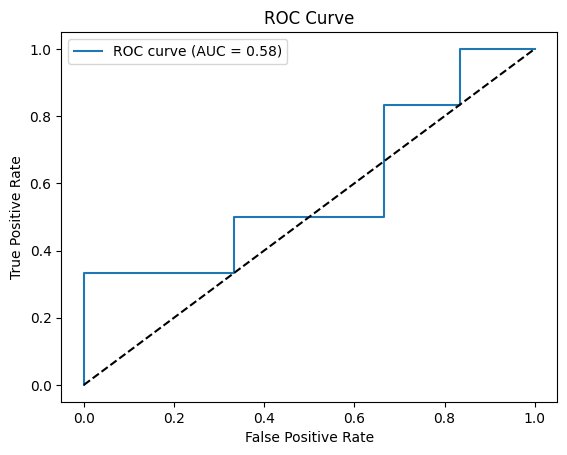

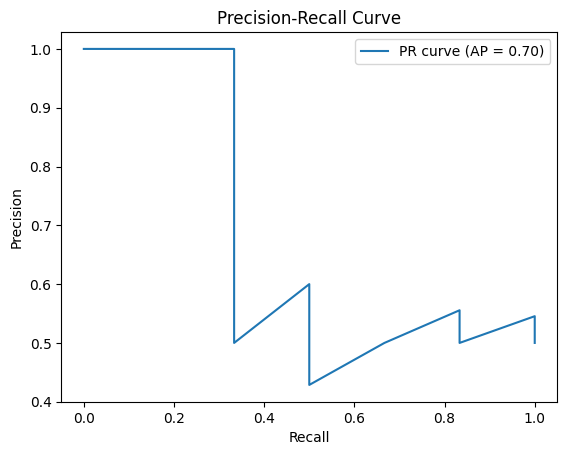

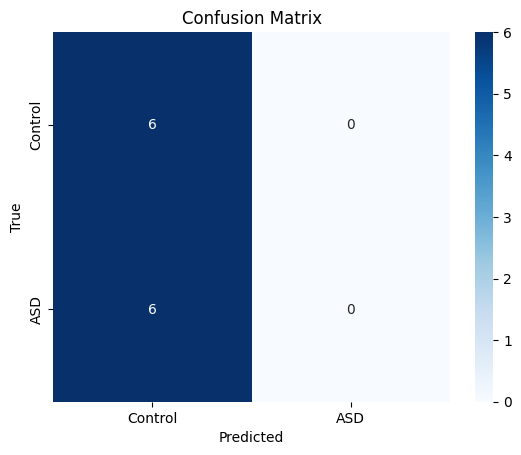

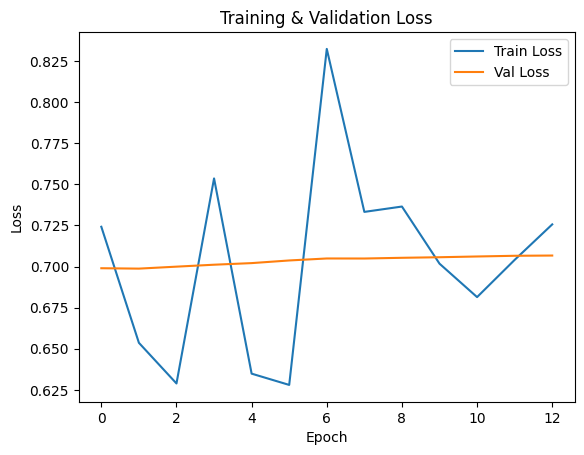

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_test, y_pred_logits, y_score = eval_epoch(model, test_loader, DEVICE)

# If y_pred_logits is logits, convert to predicted class
y_pred_classes = np.argmax(y_pred_logits, axis=1)
# For ROC and PR, use the score/probability for the positive class
y_score_pos = y_pred_logits[:, 1]  # or y_score[:, 1] if that's your probability output

print('Test Accuracy:', accuracy_score(y_test, y_pred_classes))
print('Test Precision:', precision_score(y_test, y_pred_classes))
print('Test Recall:', recall_score(y_test, y_pred_classes))
print('Test F1:', f1_score(y_test, y_pred_classes))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score_pos)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score_pos)
ap_score = average_precision_score(y_test, y_score_pos)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control','ASD'], yticklabels=['Control','ASD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Training/Validation Loss
plt.figure()
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


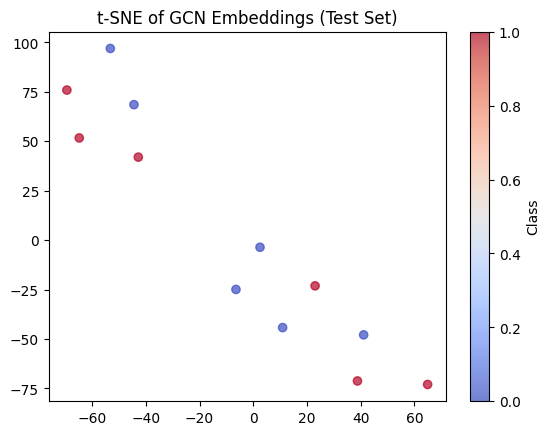

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeddings = []
tsne_labels = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(DEVICE)
        x = F.relu(model.bn1(model.conv1(data.x, data.edge_index)))
        x = global_mean_pool(x, data.batch)
        embeddings.append(x.cpu().numpy())
        tsne_labels.extend(data.y.cpu().numpy())
embeddings = np.vstack(embeddings)

n_samples = embeddings.shape[0]
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, n_samples-1))
z = tsne.fit_transform(embeddings)

plt.figure()
plt.scatter(z[:,0], z[:,1], c=tsne_labels, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE of GCN Embeddings (Test Set)')
plt.colorbar(label='Class')
plt.show()


---

Clustering Approach for Available Data

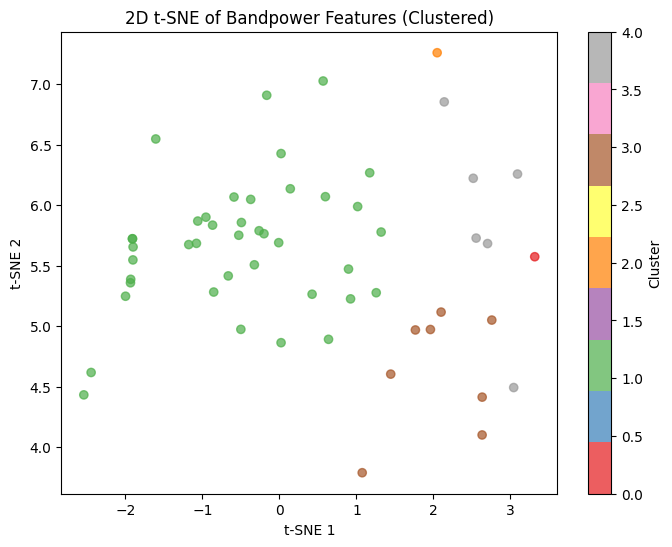

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X_scaled = StandardScaler().fit_transform(all_features)

# KMeans Clustering (change n_clusters as needed)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
np.save('cluster_labels.npy', cluster_labels)

# 2D t-SNE Plot
tsne_2d = TSNE(n_components=2, random_state=42)
X_2d = tsne_2d.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=cluster_labels, cmap='Set1', alpha=0.7)
plt.title('2D t-SNE of Bandpower Features (Clustered)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')
plt.show()

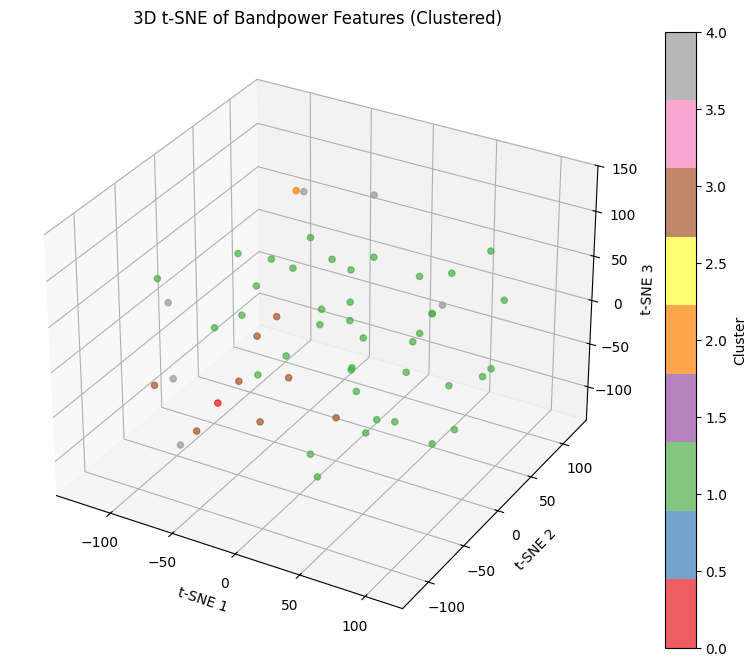

In [ ]:
# 3D t-SNE Plot (Optional)
tsne_3d = TSNE(n_components=3, random_state=42)
X_3d = tsne_3d.fit_transform(X_scaled)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c=cluster_labels, cmap='Set1', alpha=0.7)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.title('3D t-SNE of Bandpower Features (Clustered)')
plt.colorbar(sc, label='Cluster')
plt.show()